In [1]:
import markdown


<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Материалы:
* [Презентация] (https://disk.yandex.ru/i/GGcL241Y4R3Cbg)

* [Дашборд] (https://public.tableau.com/views/da_66_banks_finalproject_1/Clients_Cat_Churn2?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

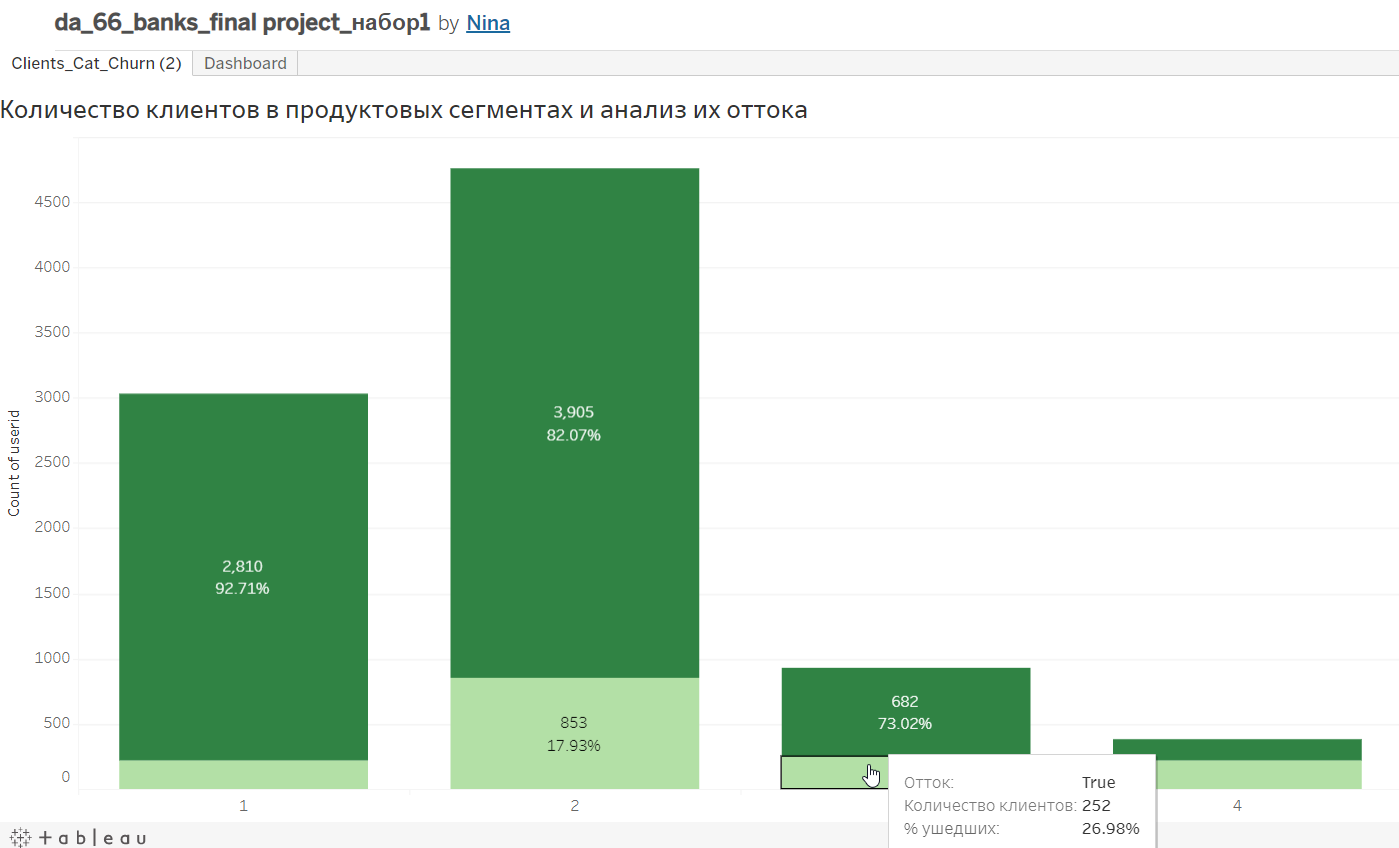

# Декомпозиция

***Заказчик:*** "Метанпромбанк".

***Пользователь результатов анализа:*** менеджер банковских продуктов.

***Главная задача работы с данными:*** сегментация пользователей банка по потреблению банковских продуктов в разрезе числа используемых продуктов. Анализ покажет, как клиенты пользуются услугами банка, а также поможет нам составить портрет клиентов, которые склонны уходить из банка и предложить решение по уменьшению оттока клиентов.

**Декомпозиция работы:**
1. Открытие файла с данными и загрузка необходимых библиотек
3. Ознакомление с данными
2. Предобработка данных:
    - поиск и обработка пропусков
    - поиск и обработка дубликатов
    - поиск и обработка выбросов
3. Исследовательский анализ данных:
    - построение общих графиков для изучения распределения
    - автоматизация и subplots
    - построение матрицы корреляций на числовых признаках
4. Сегментация:
    - графики в разрезе признака, по которому происходит сегментация
    - описание портретов получившихся сегментов
5. Статистическая проверка гипотез:
    - формулировка гипотез
    - проверка гипотез
    - корректная формулировка относительно выбранного статистического критерия
6. Выводы и рекомендации:
    - описание выводов
    - формулировка рекомендаций относительно каждого сегмента: предложение банковских продуктов каждому отдельному сегменту, которые будут ему интересны (исходя из итогов проведенной работы).

# 1. Предобработка данных

## 1.1. Импорт необходимых библиотек, чтение данных и сохранение их в таблицу, изучение общих сведений о данных 

! [image.png](attachment:image.png)

In [3]:
import pandas as pd
import numpy as np
from numpy import median
import seaborn as sns
from scipy import stats as st
import math as mth
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')


## 1.2. Чтение данных и сохранение их в таблицу

In [4]:
# чтение файла bank_scrooge.csv  и сохранение его в переменную 
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
df = pd.read_csv(path)

In [5]:
df

**Описание данных:**

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity` — количество объектов в собственности,
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта,
- `last_activity` — активный клиент,
- `est_salary` — заработная плата клиента,
- `churn` — ушёл или нет.

## 1.3. Изучение данных, корректировка формата, работа с дубликатами и выбросами

**Уже видна проблема с регистром шрифта в заголовках. Приведем их к нижнему регистру:**

In [6]:
df.columns = map(str.lower, df.columns)

In [7]:
df

In [8]:
#посмотрим, какие города представлены в датасете
df['city'].unique()

In [9]:
df['equity'].sort_values().unique()

In [10]:
#изучим данные о гендере клиентов для исключения аномалий
df['gender'].unique()

Аномальных значений в столбцах city и gender нет.
Приведем столбцы 'city' и 'gender' к нижнему регистру:

In [11]:
df['city'] = df['city'].str.lower()
df['gender'] = df['gender'].str.lower()
df.head()

In [12]:
#посмотрим на информацию о датафрейме и его размере
df.info()

Всего 10 000 записей и 12 столбцов, содержащих как числовые, так и категориальные данные. Нечисловыми являются столбцы 'city' и 'gender'. Столбцы credit_card, last_activity, churn далжны быть приведены к типу bool, так как имеют значения 0 и 1

In [13]:
# меняем типы данных в столбцах, требующих булевые значения, а не числовые
df['credit_card'] = df['credit_card'].astype('bool')
df['last_activity'] = df['last_activity'].astype('bool')
df['churn'] = df['churn'].astype('bool')
df.info()

In [14]:
df['gender_type'] = df['gender'].replace({'ж':0, 'м': 1})

In [15]:
df.head(5)

In [17]:
df['gender_type'] = df['gender_type'].astype('bool')

In [18]:
df.head()

In [19]:
#df['gender'] = df['gender'].map({'М':1, 'Ж':0})

#добавим столбцы, в которых заменим нечисловые данные на числовые
df['gender_num'] = df['gender_type'].map({True:1, False:0})
df['credit_card_num'] = df['credit_card'].map({True:1, False:0})
df['last_activity_num'] = df['last_activity'].map({True:1, False:0})
df['churn_num'] = df['churn'].map({True:1, False:0})

In [20]:
#закодируем города для дальнейшего анализа и добавим их в отдельные столбцы
df = df.join(pd.get_dummies(df.city))

In [21]:
df.head()

In [22]:
#посмотрим описательную статистику для столбцов числового типа
df.describe()

In [23]:
#ищем явные дубликаты
df.duplicated().sum()

Явные дубликаты отсутствуют

**Проверим, есть ли записи с одинаковыми userid и запишем их в отдельный датафрейм, чтобы проверить, почему они дублируются:**

In [24]:
userid_duplicated = df['userid'].value_counts().sort_values()
userid_duplicated = userid_duplicated.reset_index()

In [25]:
userid_duplicated.info()

In [26]:
userid_duplicated = userid_duplicated.rename({'index': 'user_id', 'userid': 'count'}, axis = 1)
userid_duplicated

In [27]:
userid_duplicated = userid_duplicated.loc[userid_duplicated['count'] == 2]
userid_duplicated

In [28]:
# смотрим дубликаты
USERID, GENDERCOL = 'userid', 'gender_type'
df_userid_dups = df[df.duplicated(keep='first',subset=USERID)]\
                    .merge(df[df.duplicated(keep='last',subset=USERID)],on=USERID) 
df_userid_dups = df_userid_dups[df_userid_dups.columns.sort_values()].sort_values(['age_x','balance_x'])
df_userid_dups['diff'] = (1 - df_userid_dups.balance_x / df_userid_dups.balance_y)\
                       + (1 - df_userid_dups.est_salary_x / df_userid_dups.est_salary_y)\
                       + (1 - df_userid_dups.score_x / df_userid_dups.score_y)
df_userid_dups.sort_values('diff')[['city_x', 'city_y', GENDERCOL + '_x', GENDERCOL + '_y', 'age_x', 'age_y', 'equity_x','equity_y']].head(50)

In [29]:
df_userid_dups

У нас есть разные записи с одинаковым id клиента. Всего 73 userid с двумя записями в датасете.

Даже на первый взгляд мы видим, что эти записи релевантны. Клиенты банка имеют счета в разных городах, поэтому их id повторяются в датасете

**Изучим данные о возрасте клиентов:**

In [31]:
df['age'].sort_values().unique()

В age есть пропуски. Возраст клиентов в диапазоне 18 - 86 лет

Пропуски есть в age и в balance.

## 1. 4. Обработка выбросов

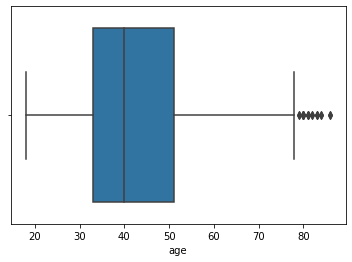

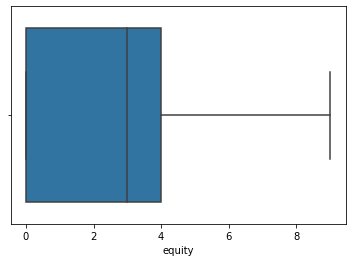

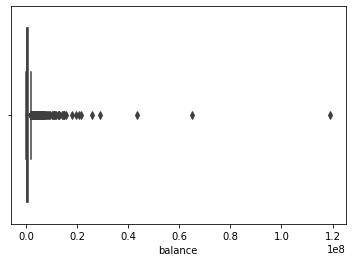

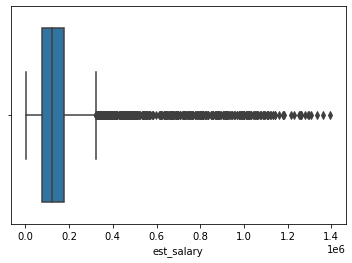

In [32]:
for column in ['age', 'equity', 'balance', 'est_salary']:
    plt.figure()
    sns.boxplot(x=column, data=df)
    plt.show()

**Выбросы есть в 'age', а 'balance' и 'est_salary'**

In [33]:
#посмотрим процент клиентов старше 77 лет
print('Количество клиентов старше 77 лет:', len(df.query('age > 77')))
print('Процент от общего числа:', round(len(df.query('age > 77'))/len(df)*100, 2))

Количество клиентов возрастом более 77 лет незначительное и составляет 0.28%.

In [34]:
# Можем удалить пропуски в age, тк их количество незначительно и в дальнейшем повлияет на результаты анализа
df.dropna(subset=['age'], inplace=True)

**Изучим 'est_salary':**

In [35]:
df['est_salary'].describe().round(2)

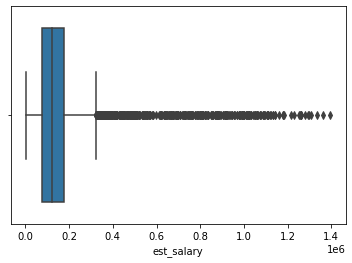

In [36]:
sns.boxplot(x = df['est_salary'])

In [37]:
df['est_salary'].median() 

In [38]:
df['est_salary'].quantile(0.9)

In [39]:
df['est_salary'].quantile(0.95)

**90% клиентов имеют зарплату менее 242 395.5, тогда как максимальное значение зп в df равно 1 395 064.45. Возможно, эти клиенты входят в отдельную категорию VIP-клиентов - стоит присмотреться к ним.**

**Посмотрим на показатели'balance':**

In [40]:
df['balance'].describe()

In [41]:
df['balance'].median()

In [42]:
print('Количество клиентов с балансом выше 1 000 000:', len(df.query('balance > 1000000')))
print('Процент от общего числа:',len(df.query('balance > 1000000'))/len(df)*100)

In [43]:
print('Количество клиентов с балансом выше 1 850 000:', len(df.query('balance > 1850000')))
print('Процент от общего числа:',len(df.query('balance > 1850000'))/len(df)*100) 

**Далее следует также рассмотреть отдельно  клиентов с балансом выше 1.5 млн.**

## 1.5. Обработка пропусков

 ***Исследуем пропуски в  'balance'. Для этого создадим отдельный датафрэйм с пропущенными значениями в столбце 'balance'. Попробуем найти закономерность и, по возможности, заменить пропуски логическими значениями.***

In [44]:
# проверим baalance на пропуски еще раз
df['balance'].isna().sum()

In [45]:
#создадим отдельный датасет для изучения пропусков в данных по balance
nan_bal = df[['score','city', 'gender', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'churn']]

#создадим колонку, которая будет показывать, нулевой балас или нет, в конкретной записи
nan_bal['nan_bal'] =  pd.isnull(nan_bal['balance'])

In [46]:
#напишем функцию, которая распределяет баллы score по категориям для более наглядного анализа в данном случае
def score_category(nan_bal):
    
    if nan_bal['score'] <= 800:
        return 'до 800 баллов'
    
    elif nan_bal['score'] <= 900:
        return '801-900 баллов'
    
    else:
        return '901+ баллов'

#добавим новый столбец в таблицу
nan_bal['score_category'] = nan_bal.apply(score_category, axis=1)

nan_bal.head(3)

In [47]:
#функция для выведения процентов в countplot
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

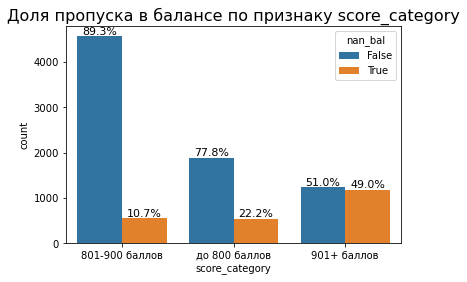

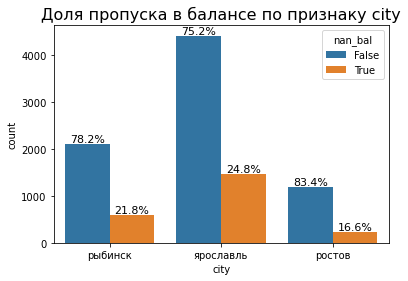

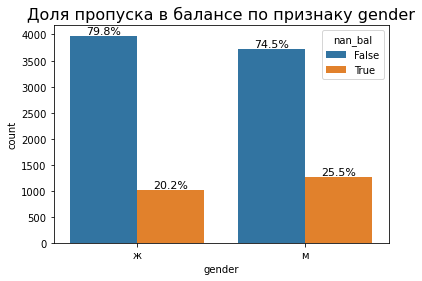

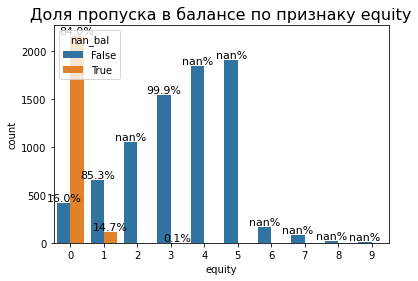

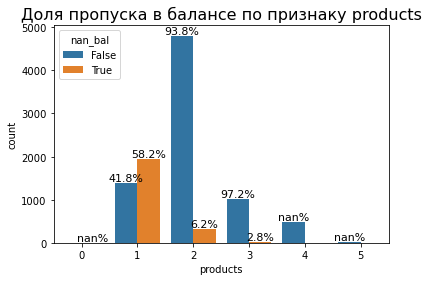

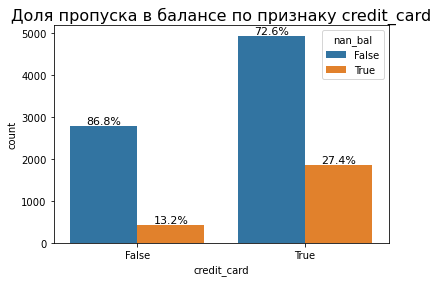

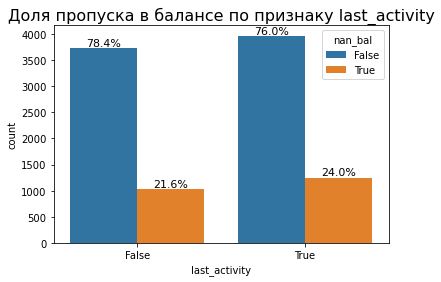

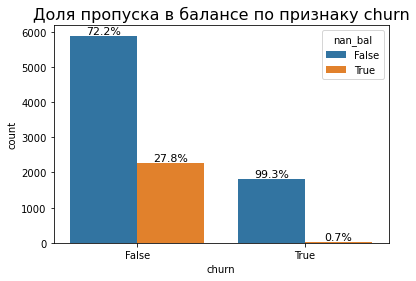

In [48]:
#рассмотрим соотношение пропусков по некоторым категориальным и количественным показателям
for column in ['score_category','city','gender','equity','products','credit_card','last_activity','churn']:
        ax = sns.countplot(data=nan_bal, x=column, hue='nan_bal')
        #sns.set_palette('YlGn_r')
        plt.title(f'Доля пропуска в балансе по признаку {column}', fontsize = 16, color = 'black')
        #plt.legend(['null', 'not null'])
        percentage_above_bar_relative_to_xgroup(ax)
        plt.show() 

**По кредитному рейтингу:**
49.0% клиентов с рейтингом 900+ имеют пропуски в записях о балансе\
**Среди городов:**
В Ярославле самое большое соотношение пропущенных значений баланса к непропущенным (24.0%). В Рыбинске 21.8% пропусков. В Ростове - 16.6%\
**По полу:**
Соотношение немного выше у мужчин (25.5% у М и 20.2% у Ж) \
**По собственности:**
Больше всего пропусков в балансе у клиентов, которые не имеют объектов в собственности. 84% записей таких клиентов имеют пропуски в балансе. У клиентов с 1 объектом 14.7% пропусков\
**По количеству продуктов:**
Пропуски в записях о балансе содержатся у 58.2% клиентов с 1 банковским продуктом. С 2 банковскими продуктами таких клиентов 5.2%. Остальные записи практически не имеют пропуски по данному признаку (с 4 и 5 продуктами пропусков нет).\
**По наличию кредитной карты:**
Пропуски в balance у 27.4% клиентов с кредитной картой и 13.2% у клиентов без кредитной карты\
**По активности:**
У неактивных и активных клиентов соотношение не имеет существенного различия (21.6% и 24.0%)\
**По оттоку:**
Существующие клиенты банка в 27.8% случаев имеют пропуски в данных о балансе. Отточные клиенты практически не имеют таких записей (0.7%).

**Вывод по анализу пропусков в balance:**\
Наиболее существенное количество пропусков в данных по balance у действующих банковских клиентов из Ярославля, с 0 количеством объектов в обственности, имеющих всего 1 банковских продукт, обладателей кредитных карт и клиентов со score 900+.

Логично, что NaN в balance у пользователей кредитных карт, так как расчетного дебетового счета в банке они не имеют.

Исходя из этого, можно заменить пропуски нулями, но это также может исказить результаты. А если оставить пропуски без изменения, то это также исказит результаты при анализе связи баланса с другими признаками и исключит из анализа 20% пользователей. Всего 1975 записей с пропусками, что составляет почти 20% от датасета. **Отсутствие расчетного счета и его наличие с нулевым остатком - это разные вещи.**\

Поэтому сделаем следующее: заполним пропуски в балансе нулями, но создадим дополнительный столбец с признаком, который указывает на наличие или отсутсвие расчетного счета, где 0 - нет счета, а 1 - есть счет.

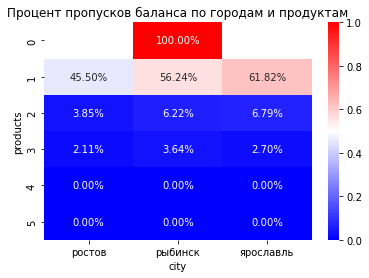

In [49]:
### КОД РЕВЬЮЕРА
sns.heatmap(
    df.pivot_table(
        index='products', 
        columns='city', 
        values='balance', 
        aggfunc=lambda row: row.isna().mean()), 
    annot=True, 
    fmt='.2%',
    cmap="bwr")\
   .set(title="Процент пропусков баланса по городам и продуктам");

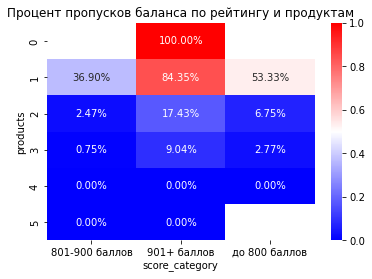

In [50]:
sns.heatmap(
    nan_bal.pivot_table(
        index='products', 
        columns='score_category', 
        values='balance', 
        aggfunc=lambda row: row.isna().mean()), 
    annot=True, 
    fmt='.2%',
    cmap="bwr")\
   .set(title="Процент пропусков баланса по рейтингу и продуктам");

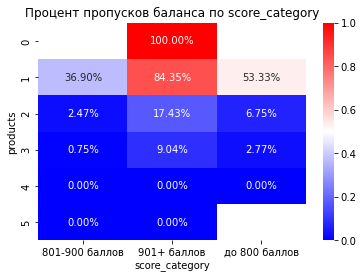

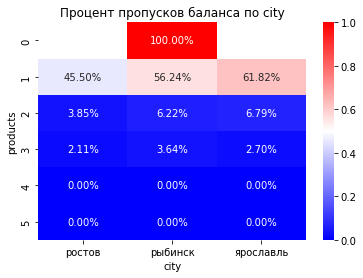

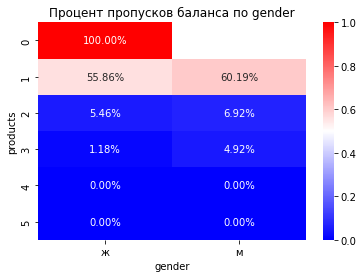

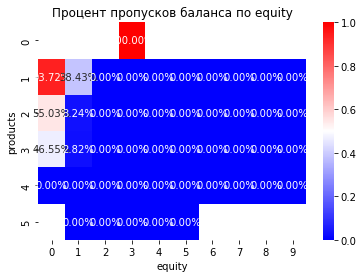

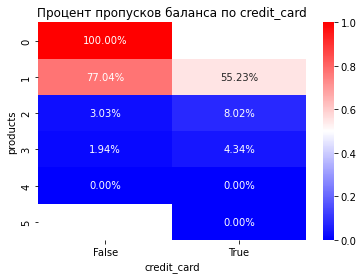

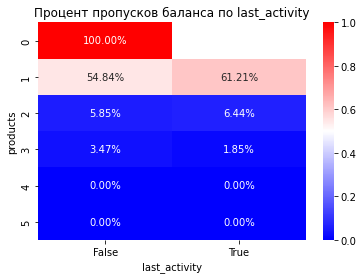

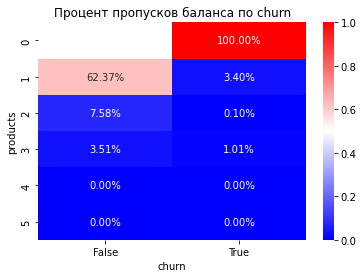

In [51]:
for column in ['score_category','city','gender','equity','credit_card','last_activity','churn']:
        fig1,ax1 = plt.subplots()
        sns.heatmap(nan_bal.pivot_table(index='products', columns=column, values='balance', aggfunc=lambda row: row.isna().mean()), 
        annot=True, 
        fmt='.2%',
        cmap="bwr")\
   .set(title=f"Процент пропусков баланса по {column}");       
 

**Создадим отдельный столбец 'pay_account', в котором 0 будет означать пропуск в показателе баланса, 1 - отсутствие пропуска:**

In [52]:
#создадим отдельный столбец 'pay_account', в котором 0 будет означать пропуск в показателе баланса, 1 - отсутствие пропуска
df['pay_account'] = df['balance'].copy() 
df['pay_account'] = df['pay_account'].fillna(0)
#df['pay_account'] = df.loc[df['pay_account'] != 0, 'pay_account'] = 1
df.loc[(df.pay_account != 0), 'pay_account'] = 1 
df['pay_account']


In [53]:
df['pay_account'].value_counts()

## Выводы по предобработке данных
- На этапе предобработки данных названия столбцов были приведены к нижнему регистру, изменены названия некоторых из них, типы данных в столбцах.
- Проведен поиск дубликатов. Определена причина, почему есть записи с одинаковыми userid: клиенты банка имеют счета в разных городах, поэтому их id повторяются в датасете
- Изучены и удалены выбросы в данных в age и est_salary. 
- Найдена связь пропусков в 'balance' с наличием кредитной карты и владением всего 1 банковским продуктом. Принято решение заполнить пропуски в балансе нулями, но создать дополнительный столбец 'pay_account' с признаком, который указывает на наличие (1) или отсутсвие (0) расчетного счета, где 0 - нет счета, а 1 - есть счет. Если просто заполнить пропуски нулями или удалить их, то данные будут искажены, так как изменению подвергнутся почти 20% датасета.


# 2. Исследовательский анализ данных (EDA)

## 2.1. Общий портрет клиентов банка и распределение по  признакам

## 2.2. Общее распределение по количественным признакам

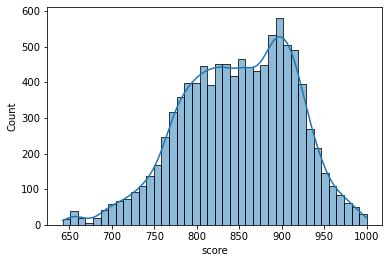

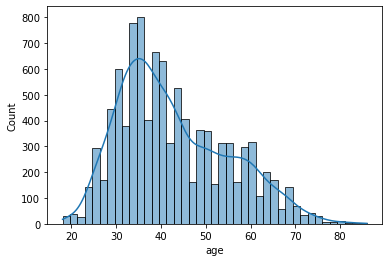

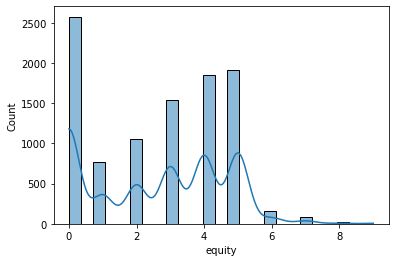

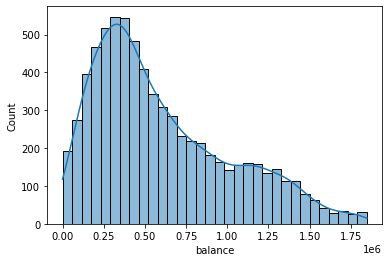

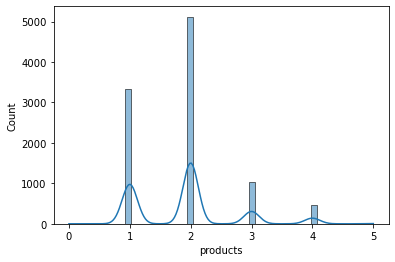

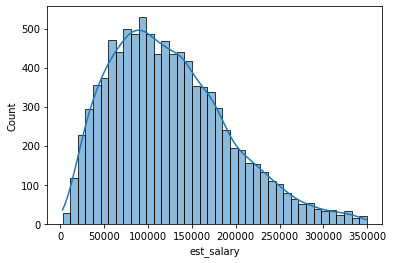

In [54]:
for column in ['score','age','equity', df.query('balance < 1850000')['balance'],\
               'products', df.query('est_salary < 350000')['est_salary']]:
    #ax = plt.subplot(6)
    fig1,ax1 = plt.subplots() 
    sns.histplot(data = df, x = column, kde = True,  palette='ocean')

- У большинства клиентов кредитный рейтинг выше среднего
- больше всего клиентов в возрасле 30-40 лет
- у большинства из них 0 объектов в собственности, затем 5 объектов и 3 объекта
- наиболее частый баланс на счете не превышает 500 тыс. у.е.
- чаще всего клиенты используют 2 продукта, реже всего - 5
- наиболее частотная зарплата близится к 100 тыс. у.е.

Распределения значений balance, age, est_salary близки к распределению Пуассона.

## 2.3. Общее распределение по категориальным признакам 

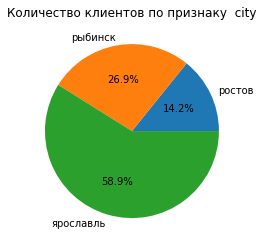

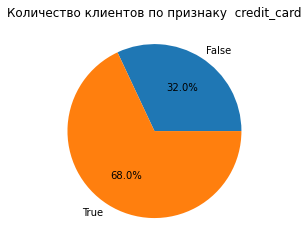

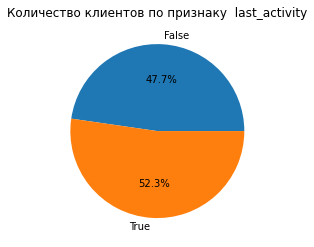

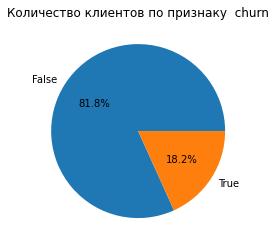

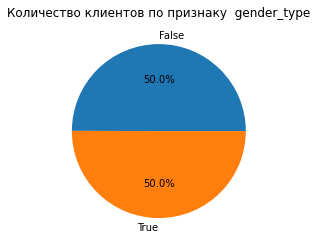

In [55]:
group3 = df.groupby(['city','credit_card','last_activity', 'churn','gender_type'])['userid'].count().reset_index()
group3

for i in ['city','credit_card','last_activity', 'churn','gender_type']:    
    df_pie = group3.groupby(i).agg({'userid': 'sum'})
    fig1,ax1 = plt.subplots()    
    ax1.pie(df_pie['userid'], labels=df_pie.index, autopct='%1.1f%%')
    ax1.set_title(f'Количество клиентов по признаку  {i}')    
    plt.show()

**Выводы по распределению по категориальным показателям:**
- большинство клиентов в датасете из Ярославля
- 68.0% клиентов имеют кредитную карту
- 52.3% являются активными
- 81.8% клиентов не разрывали отношения с банком
- 50 % являются женщинами

## 2.4. Распределение количественных показателей в разрезе оттока¶

**Построим нормализованные гистограммы для непрерывных переменных с разделением по оттоку:**

In [56]:
#распределение показателей баланса:
import plotly.express as px

fig = px.histogram(df, x=df.query('balance < 1850000')['balance'], histnorm='probability density')
fig.show()

for column in ['score','age','equity', df.query('balance < 1850000 or balance.isna()==True')['balance'],\
               'products', df.query('est_salary < 350000')['est_salary']]:
    #ax = plt.subplot(6)
    fig1,ax1 = plt.subplots() 
    sns.histplot(data = df, x = column, kde = True, hue = "churn", stat="density", common_norm=False,  palette='ocean')
    #plt.ylabel('Количество клиентов')
    #plt.title(f'Распределение клиентов по признаку {column}')

sns.histplot(data = df, x = df.query('balance <= 2000000')['balance'], \
             kde = True, hue = "churn", stat="density", common_norm=False,  palette='ocean')

**Показатели баланса ограничим, так как на фактических данных гистограмма не явлется наглядной.**

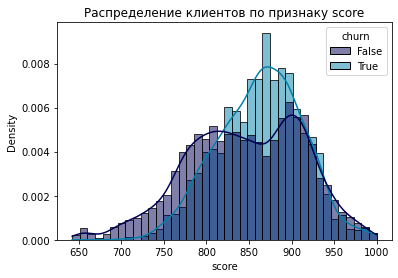

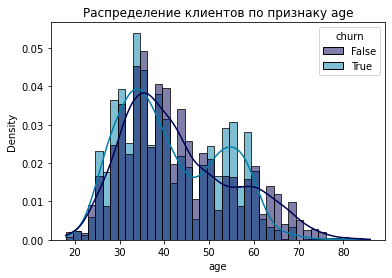

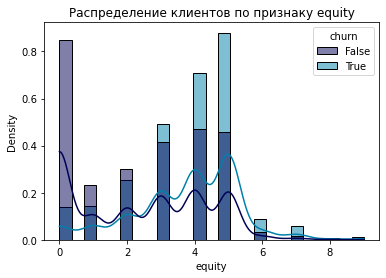

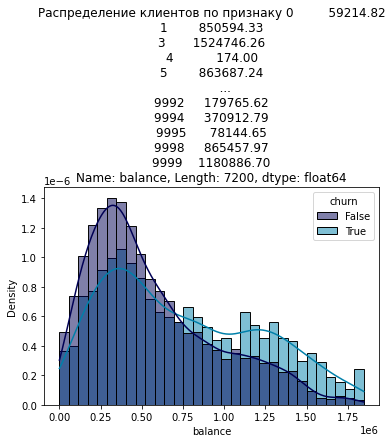

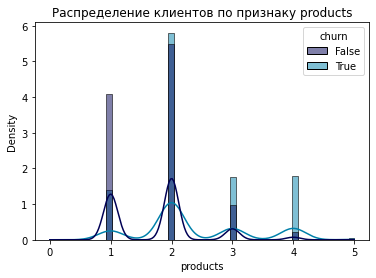

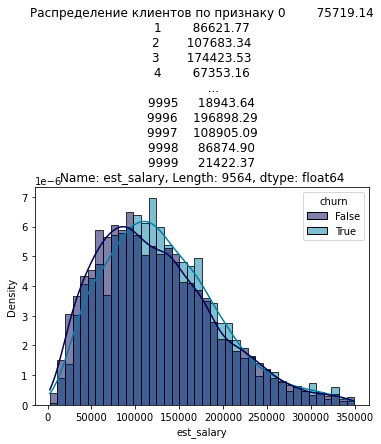

In [57]:
for column in ['score','age','equity', df.query('balance < 1850000')['balance'],\
               'products', df.query('est_salary < 350000')['est_salary']]:
    #ax = plt.subplot(6)
    fig1,ax1 = plt.subplots() 
    sns.histplot(data = df, x = column, kde = True, hue = "churn", stat="density", common_norm=False,  palette='ocean')
    #plt.ylabel('Количество клиентов')
    plt.title(f'Распределение клиентов по признаку {column}')

**Выводы по нормализованным гистограммам для непрерывных переменных с разделением по оттоку:**

- отточных клиентов больше с рейтингом 820-910 и 920-940
- 26 лет-32 года и 50-60 лет
- от 3 объектов в собственности и выше
- с балансом выше 750 т.р.
- с 2 и более продуктами
- с зп 110 тр – 140 тр, 150 тр – 175 тр, 180 тр – 217 тр, 260 тр, 320 тр, 375 тр.

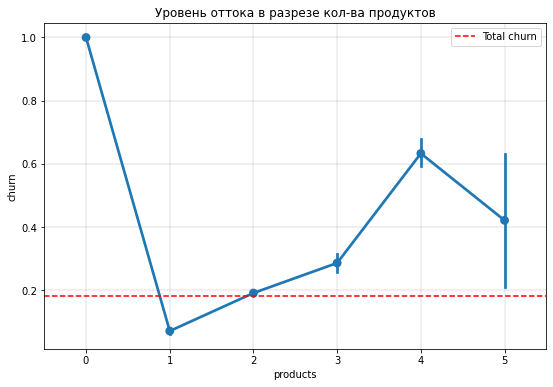

In [58]:
fig, ax = plt.subplots(figsize=(9,6))

sns.pointplot(data=df, x='products', y = 'churn', ax = ax)
ax.set_title('Уровень оттока в разрезе кол-ва продуктов')
ax.grid(c='grey', lw = 0.25)
ax.axhline(df['churn'].mean(), label='Total churn', ls='--', c='red')
ax.legend()

plt.show()

## 2.5. Распределение категориальных показателей в разрезе оттока¶

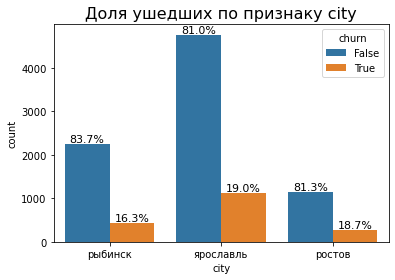

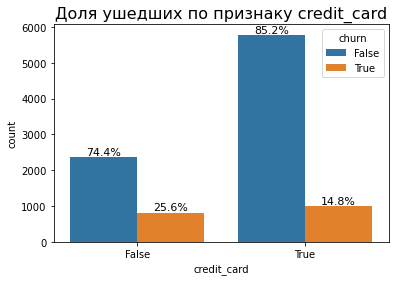

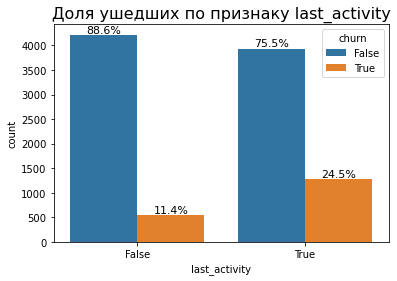

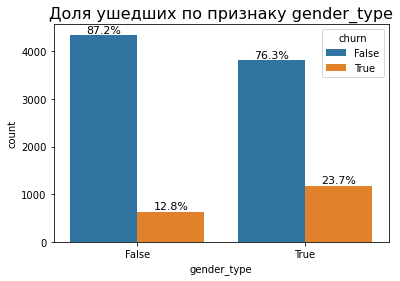

In [59]:
for column in ['city','credit_card','last_activity','gender_type']:
        ax = sns.countplot(data=df, x=column, hue='churn')
        #sns.set_palette('YlGn_r')
        plt.title(f'Доля ушедших по признаку {column}', fontsize = 16, color = 'black')
        #plt.legend(['null', 'not null'])
        percentage_above_bar_relative_to_xgroup(ax)
        plt.show() 

**Вывод:**
- чаще уходят пользователи из Ярославля и Ростова (19% и 18.7% соответственно покидают банк, из Рыбинска отток равен 16.3%)
- склонны уходить пользователи, не имеющие кредитной карты (25.6% без крединой карты против 14.8% с кредитной картой)
- активные пользователи уходят чаще (24.5% против 11.4%)
- мужчины чаще разрывают отношения с банком (23.7% М против 12.8% Ж)

## 2.6. Категоризация по количеству продуктов

**В целях выполнения задач нашего анализа по категоризации клиентов, исходя из количества продуктов, а также проанализировав гистограмму распределения, можно провести следующее разделение на продуктовые категории:**
- 1 сегмент - потребители с 1 продуктом
- 2 сегмент: потребители с 2 продуктами
- 3 сегмент: потребители с 3-5 продуктами

***Причины подобного разделения:***\
записи с 1 и с 2-мя продуктами являются самыми многочисленными и стоит определить их в две разные категории, также это подтверждают графики и медианные показатели уходящих и неуходящих клиентов . Записи с 3, 4 и 5-ю продуктами следует объединить в одну категорию. Тогда численность категорий будет распределена равномерно.

**Категоризация по количеству продуктов:**

In [60]:
#напишем функцию, которая распределяет количество продуктов по категориям
def products_category(df):
    
    if df['products'] == 1:
        return '1 продукт'
    
    elif df['products'] == 2:
        return '2 продукта'
    
    else:
        return '3-5 продуктов'

#добавим новый столбец в таблицу
df['products_category'] = df.apply(products_category, axis=1)

## 2.7. Анализ распределения количественных показателей в разрезе продуктовых категорий
**Рассмотрим непрерывные переменные в разрезе выделенных продуктовых категорий:**

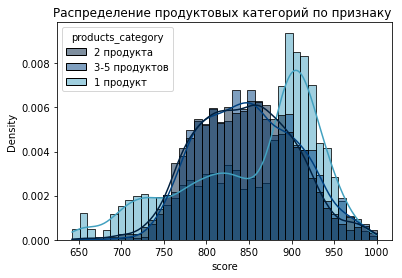

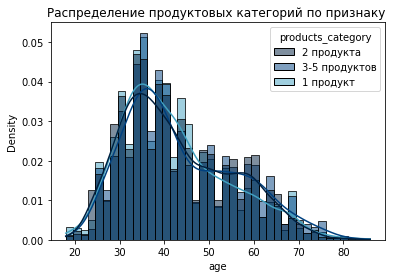

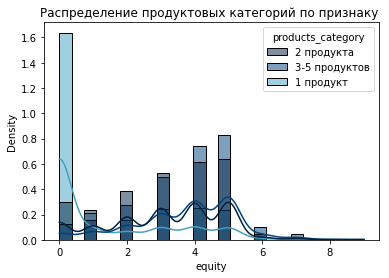

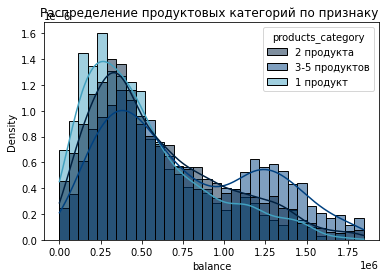

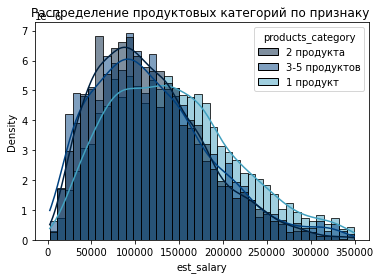

In [61]:
for column in ['score','age','equity', df.query('balance < 1850000')['balance'],\
                df.query('est_salary < 350000')['est_salary']]:
    #ax = plt.subplot(6)
    fig1,ax1 = plt.subplots() 
    sns.histplot(data = df, x = column, kde = True, hue = "products_category", stat="density", common_norm=False, palette='ocean')
    #plt.ylabel('Количество клиентов')
    plt.title(f'Распределение продуктовых категорий по признаку ')

**Основные и примечательные выводы по графику:**
- среди первой категории больше клиентов с ретингом 640-750, 875-960, среди второй и третьей:  760-860 баллов
- по age распределение категорий примерно одинаковое
- с 1 продуктом больше клиентов 0 объектами собственности во владении, в 3 категории клиенты владеют 1 и более объектами, 2 категория клиентов в большинстве случает имеет 0-5 объектов
- из 1 категории баланс редко превышает 375 тыс., у категории 2 ...., у 3 категории превалирует баланс свыше 1.125 млн, у 2 категории чаще встречается баланс до 500 т.р.
- категория 1 чаще имеет зп от 150 тр, 2 категория - до 150 тр, 3 категория - до 150 тр.

### 2.7.1. Категоризация признаков, исходя из диаграмм распределения:

**Категоризация по числу объектов в собственности:**

In [62]:
#напишем функцию по категоризации по числу объектов в собстенности
def equity_category(df):
    
    if df['equity'] == 0:
        return 'нет объектов'
    
    elif df['equity'] < 4:
        return '1-3 объекта'
    
    else:
        return 'более 4 объектов'

#добавим новый столбец в таблицу
df['equity_category'] = df.apply(equity_category, axis=1)

**Категоризация по балансу на счете:**

In [63]:
#напишем функцию по категоризации по балансу на счете
def balance_category(df):
    
    if df['balance'] == 0:
        return 'нулевой баланс'
    
    elif df['balance'] <= 680000:
        return '1-680 тыс.'
    
    elif df['balance'] <= 1750000:
        return '681-1.75 млн.'
    
    elif df['balance'] > 1750000:
        return '1.76 млн.+'
    
    else:
        return 'NaN'

#добавим новый столбец в таблицу
df['balance_category'] = df.apply(balance_category, axis=1)


In [64]:
bal_pie = df.groupby('balance_category').agg({'userid': 'count'})

In [65]:
fig = px.pie(bal_pie, values='userid', names=bal_pie.index, title='Категории по балансу')
fig.show()

**Категоризация по возрасту:**

In [66]:
#напишем функцию, которая распределяет возраст по категориям
def age_category(df):
    
    if df['age'] <= 24:
        return '18-24 лет'
    
    elif df['age'] <= 35:
        return '25-35 лет'
    
    elif df['age'] <= 48:
        return '36-48 лет'
    
    elif df['age'] <= 62:
        return '49-62 лет'
    
    else:
        return '63+ лет'

#добавим новый столбец в таблицу
df['age_category'] = df.apply(age_category, axis=1)

In [67]:
age_pie = df.groupby('age_category').agg({'userid': 'count'})

fig = px.pie(age_pie, values='userid', names=age_pie.index, title='Категории по возрасту')
fig.show()

**Категоризация по заработной плате:**

In [68]:
#напишем функцию по категоризации по зарплате
def est_salary_category(df):
    
    if df['est_salary'] == 0:
        return 'нулевая зарплата'
    
    elif df['est_salary'] <= 90000:
        return '1-90 тыс.'
    
    elif df['est_salary'] <= 230000:
        return '90-230 тыс.'
    
    elif df['est_salary'] <= 320000:
        return '231-320 тыс.'
    
    else:
        return '321 тыс.+'

#добавим новый столбец в таблицу
df['est_salary_category'] = df.apply(est_salary_category, axis=1)

In [69]:
sal_pie = df.groupby('est_salary_category').agg({'userid': 'count'})

fig = px.pie(sal_pie, values='userid', names=sal_pie.index, title='Категории по заработной плате')
fig.show()

In [70]:
df['est_salary_category'].value_counts()

**Категоризация по баллам кредитного скоринга:**

In [71]:
#напишем функцию, которая распределяет баллы score по категориям
def score_category(df):
    
   # if df['score'] <= 750:
   #     return 'до 750 баллов'
    
    if df['score'] == 0:
        return '0 баллов'  
    
    elif df['score'] <= 820:
        return '1-820 баллов'

    elif df['score'] <= 920:
        return '821-920 баллов'
    
    else:
        return '921+ баллов'

#добавим новый столбец в таблицу
df['score_category'] = df.apply(score_category, axis=1)

df.head(3)

In [72]:
df['score_category'].value_counts()

In [73]:
score_pie = df.groupby('score_category').agg({'userid': 'count'})

fig = px.pie(score_pie, values='userid', names=score_pie.index, title='Категории по баллам кредитного скоринга')
fig.show()

## 2.8. Анализ распределения категориальных показателей в разрезе продуктовых категорий

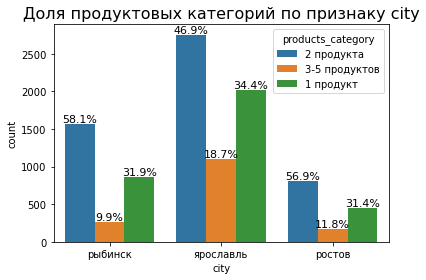

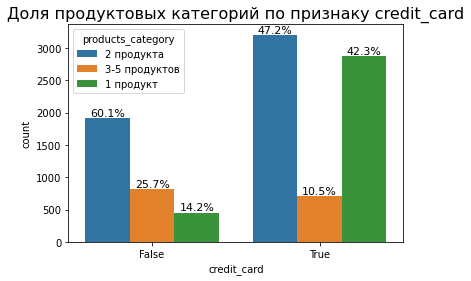

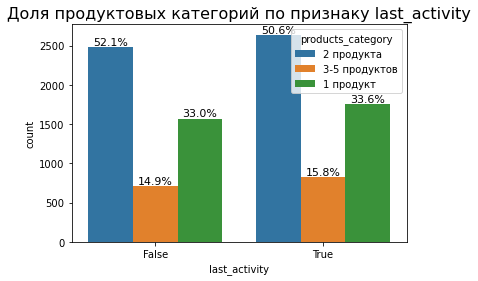

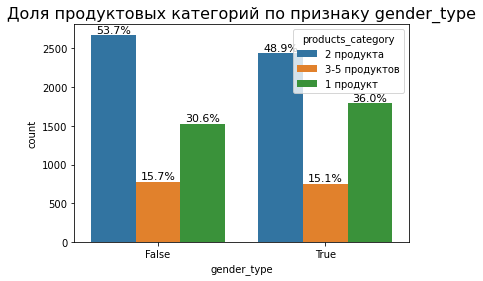

In [74]:
for column in ['city','credit_card','last_activity','gender_type']:
        ax = sns.countplot(data=df, x=column, hue='products_category')
        #sns.set_palette('YlGn_r')
        plt.title(f'Доля продуктовых категорий по признаку {column}', fontsize = 16, color = 'black')
        #plt.legend(['null', 'not null'])
        percentage_above_bar_relative_to_xgroup(ax)
        plt.show() 

**Выводы по графикам:**
- по городам наиболее популярным выбором пользователей является обладание двумя банковскими продуктами. Наименее популярный выбор - 3+ продуктов
- у пользователей с кредитной картой чаще 2 банковских продукта, как и у пользователей без кредитой карты. С кредитной картой реже 3-5 продуктов, а без крдетной карты наиболее редкая ситуация - 1 продукт
- у активных и неактивных клиентов чаще 2 продукта, реже - 3-5 продуктов
- у мужчин и женщин также примерно одинаковое распределение количества банковских продуктов: чаще - 2 продукта, реже 3-5 продуктов.

## 2.9. Общее распределение клиентов по выделенным категориям в разрезе оттока

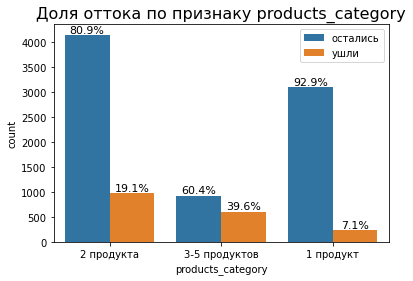

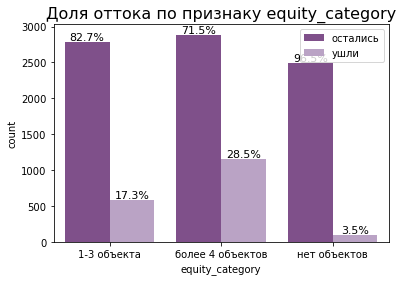

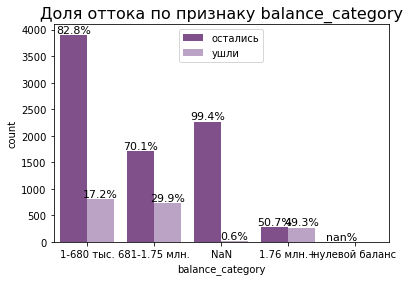

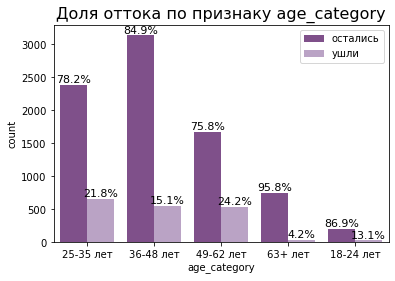

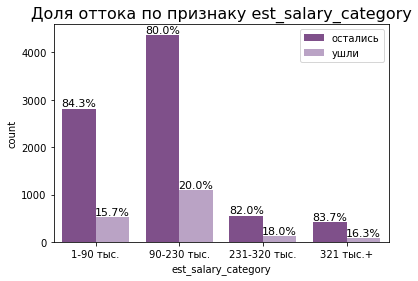

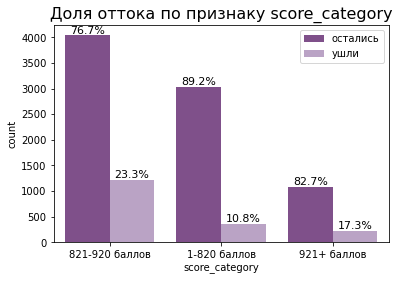

In [75]:
for column in ['products_category','equity_category','balance_category','age_category','est_salary_category','score_category']:
        ax = sns.countplot(data=df, x=column, hue='churn')
        sns.set_palette('PRGn')
        
        plt.title(f'Доля оттока по признаку {column}', fontsize = 16, color = 'black')
        percentage_above_bar_relative_to_xgroup(ax)
        plt.legend(['остались', 'ушли'])
        plt.show() 

На графиках мы видим:
- соотношение ушедших к оставшимся клиентам во всех городах примерно одинаковое и составляет примерно 1 к 5
- чаще уходят клиенты-мужчины (уходят 35% по отношению к оставшимся). У женщин подобное значение составляет 12.5%
- клиенты с кредитной картой уходят реже
- активные клиенты уходят чаще неактивных
- чаще всего уходят пользователи в возрасте 18-30 лет.

## 2.10. Анализ средних и медианных значений признаков по продуктовым категориям

In [76]:
#анализ средних значений признаков по категориям
df.groupby('products_category').agg('mean').round(2).T

In [77]:
#анализ медианных значений признаков по категориям
df.groupby('products_category').agg('median').round(2).T

Анализ средних значений признаков показывает, что во всех продуктовых категориях примерно одинаковы средние:  кредитный рейтинг, возраст, количество активных клиентов. Распределение мужчин и женщин в категориях примерно одинаково.

**Различия:**
- с увеличением количества продуктов учеличивается количество объектов в собственности
- чем больше продуктов, тем выше показатели баланса
- с 1 продуктом больше клиентов-мужчин, с 2 и 3-5 продуктами больше клиентов-женщин
- клиенты с 3-5 продуктами редко пользуются кредитными картами, с 1 и 2 продуктами - есть кредитная карта
- все клиенты в среднем активны
- клиенты с 3-5 продуктами чаще уходят из банка.



In [79]:
df_numeric = df.drop(['churn', 'userid', 'gender_type','city','products_category',\
                      'age_category', 'equity_category', 'score_category'], axis=1).columns

In [80]:
df_numeric

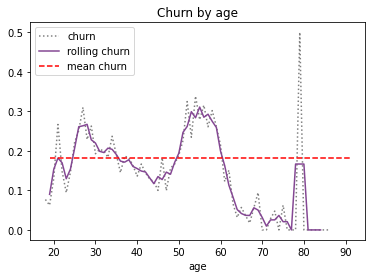

In [81]:

age_churn = df.pivot_table(values='churn',index='age')

ax = age_churn.plot(color="gray",linestyle=":")
age_churn.rolling(3,center=True).mean().set_axis(['rolling churn'],axis=1).plot(ax=ax)
ax.hlines(df.churn.mean(),19,91,ls="--",color="r",label="mean churn")
plt.legend()
ax.set(title="Churn by age");

## 2.11. Матрица корреляций и phik

### 2.11.1. Матрица корреляций

**Изучим корреляцию признаков для выявления закономерностей:**

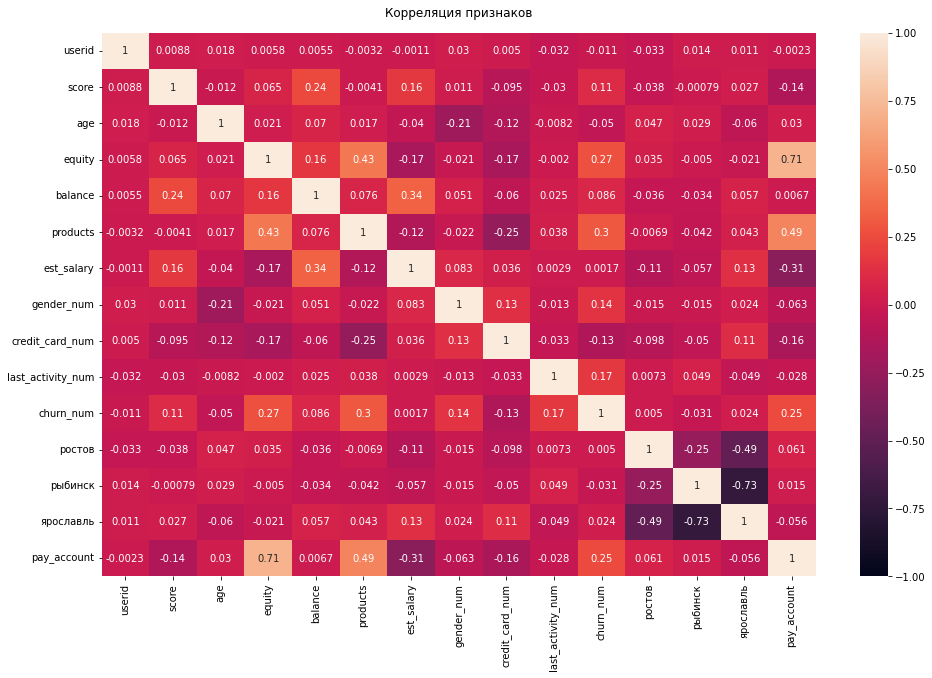

In [82]:

plt.figure(figsize=(16, 10)) 
heatmap = sns.heatmap(df.select_dtypes(include=np.number).corr(), vmin=-1, vmax=1, annot=True) 

heatmap.set_title('Корреляция признаков', fontdict={'fontsize':12}, pad=16)

### 2.12.2 Матрица phik

In [83]:
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

In [84]:
phik_matrix = df.select_dtypes(include=np.number).phik_matrix()
phik_matrix

In [85]:
phik_matrix_2 = df.select_dtypes(include=np.number).phik_matrix(interval_cols=['balance','est_salary','age','score'])

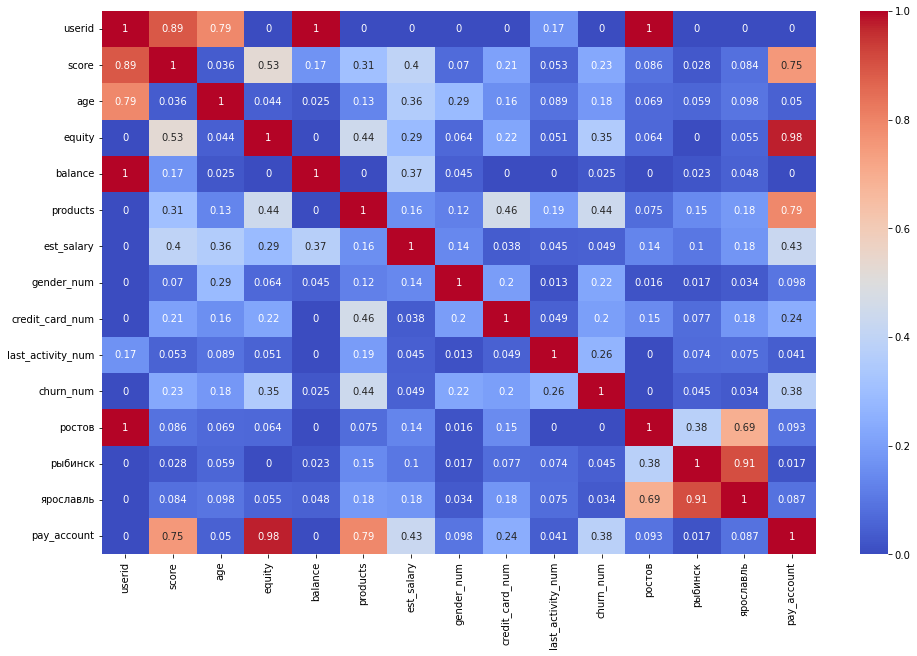

In [86]:
plt.figure(figsize=(16, 10)) 
sns.heatmap(phik_matrix_2, annot=True, cmap='coolwarm')
heatmap.set_title('Корреляция признаков', fontdict={'fontsize':12}, pad=16)

## Выводы по матрице корреляций и по phik

В разрезе шкалы Чеддока наиболее сильная связь у (согласно phik):
- объектов в собственности и дебетового счета (сильная) (0.97)
- рейтинга и наличия дебетового счета (сильная) (0.8)
- объектов в собственности и баланса (умеренная) (0.6)
- объектов в собственности и количества продуктов (умеренная) (0.57)
- продуктов и наличия дебетового счета (умеренная) (0.48)
- зарплаты и наличия дебетового счета (умеренная) (0.47)

**Относительно ухода клиентов:**
- чем больше банковских продуктов у потребителей, тем чаще они уходят (корреляция 0.23 по phik и 0.27 по матрице корреляций)
- клиенты с кредитными картами уходят реже (корреляция небольшая и отрицательная (-0.11 по корреляционной матрице, 0.17 по phik)
- чем больше объектов в собственности, тем чаще уходят клиенты (положительная корреляция: 0.25, 0.32 по phik)
- есть связь между ростом баланса и уходом клиента - чем выше баланс, тем вероятнее уход (0.18 по матрице корреляций и 0.25 по phik).

Также заметно, что:
- чем больше объектов в собственности у клиента, тем большим количеством банковских продуктов он обладает. Но мы также выявили, что связь количества банковских продуктов, а также количества объектов в собственности, с уходом клиентов прямая.
- клиенты с кредитными картами пользуются меньшим количеством банковских продуктов и уходят реже
- чем выше баланс пользователя, тем меньше вероятность обладания кредитной картой
- у клиентов увеличесние зарплаты имеет обратную зависимость с количеством банковских продуктов
- сильная положительная зависимость между суммой на балансе и количеством объектов в собственности

**Наиболее влияющие на отток признаки:**
- наличие дебетового счета (0.36)
- количество объектов в собственности (0.32)
- баланс (0.25)
- активность (0.25)
- рейтинг (0.24)
- количество продуктов (0.23)
- гендер (0.2)

**Выводы из графиков сегментации клиентов по количеству потребляемых продуктов в разрезе количественных признаков:**
- клиенты с высоким рейттингом 900+ чаще имеют 1 продукт
- клиенты с высоким балансом владеют бОльшим количеством продуктов
- медианная зарплата выше у потребителей, имеющих 1 продукт. У потребителей сегмента 2 и сегмента 3 распределение з.п. примерно одинаковое, но также в данных сегментов больше выбросов в сторону увеличения з.п. до 325 тыс. у.е.
- клиенты, имеющие 0-3 объекта во владении чаще имеют 1 банковский продукт, у сегмента 2 чаще 2-4 объекта собственности во владении, сегмент 3 в основном имеет 3-5 объектов.

**Графики показывают следующее**
- во всех городах больше всего клиентов сегмента 2, меньше - сегмента 3
- клиенты, имеющие 2 продукта, чаще всего обладают кредитной картой. Клиенты, не имеющие кредитной карты, также чаще владеют 2 банковскими продуктами. Пользователи сегмента 3 чаще не имеют кредитной карты. У клиентов без кредитной карты реже всего наблюдается 1 продукт в пользовании
- сегмент 2 в большей степени активен, чем сегменты 1 и 3. Неактивные клиенты распределены также: сначала сегмент 2, затем сегменты 1 и 3
- и мужчины и женщины чаще пользуются 2 банковскими продуктами, а реже - 3-5. Женщины пользуются 2 продуктами чаще мужчин.
- клиенты с 2 продуктами реже покидают банк относительно владельцев 1 и 3-5 продуктов. При этом, клиенты с 2 продуктами также чаще покидают банк относительно других сегментов, но доля покинувших сегмента 2 составляет примерно 18.3% от тех, кто остался. Тогда как доля ушедших сегмента 3 составляет 50%. Отношение ушедших клиентов к оставшимся в сегменте 1 равна примерно 9% - из чего делаем вывод, что клиенты с 1 продуктом реже разрывают отношения с банком.

**Выводы из графиков сегментации клиентов по количеству потребляемых продуктов в разрезе неколичественных признаков:**
- соотношение сегментов по количеству продуктов примерно одинаковое во всех городах. Чаще у клиентов во всех городах 2 продукта.В Ростове и Рыбинсе соотношение количества клиентов Сегмента 1 к Сегменту 2 примерно одинаково и равно 1 к 2 (или 50%). В Ярославле респределение немного другое: соотношение С1 к С2 = 70%. Во всем городах Сегмент 3 самый малочисленный
- и мужчины и женщины примерно одинаково соотносятся: чаще всего и у мужчин и у женщин по 2 банковских продукта, затем 1 банковский продукт, на третьем месте - 3-5 продуктов
- у клиентов с кредитной картой чаще 2 продукта, но также велико процентное соотношение владельцев 1 продукта (примерно 85% от численности Сегмента 2), в отличие от тех, у кого нет кредитной карты - у них чаще 2 банковских продукта, но 1 продукт встречается намного реже(в соотношении 1 к 4), тогда как сегмент 3 составляет примерно 40% от Сегмента 2.
- активные и неактивные клиенты по процентному количеству продуктов соотносятся примерно одинаково и чаще владеют двумя продуктами
- люди категории "31-60 лет" потребляют больше продуктов, молодые (18-30 лет) и клиенты 60+ потребляют примерно одинаковое количество банковских продуктов. По количественному соотношению у всех трех групп опять же лидирует владнеие 2 банковскими продуктами, а затем 1 и 3-5
- клиенты с 2 продуктами реже покидают банк относительно владельцев 3-5 и 1 продуктов. При этом, клиенты Сегмента 2 также чаще покидают банк относительно других сегментов, но доля покинувших сегмента 1 составляет примерно 18.3% от тех, кто остался. Тогда как доля ушедших сегмента 3 составляет 50% от Сегмента 2. Отношение ушедших клиентов к оставшимся в сегменте 3 равна примерно 50% - из чего делаем вывод, что клиенты с 3-5 продуктами чаще разрывают отношения с банком. Реже всего уходят клиенты Сегмента 1, соотношение ушедших к оставшимся составляет около 8%.

## Общие выводы по исследовательскому анализу данных

- клиенты с кредитной картой уходят реже
- процент оттока растет с увеличением количества продуктов (чаще склонны уходить клиенты с 3-5 продуктами). При этом, с ростом количества продуктов падает число клиентов с кредитными картами
- чаще уходят клиенты-мужчины
- выше отток среди молодых клиентов в возрасте от 18 до 30 лет. Но среди клиентов с 4 продуктами, выше отток у возраста 40-60 лет
- почти не уходят клиенты всех возрастов с 0-1 объектами в собственности
- общая тенденция: чем больше объектов в собственности и чем больше банковских продуктов, тем выше показатель оттока


# 3. Сегментация клиентов 

## 3.1. Соотношение количества клиентов по количеству потребляемых банковских продуктов

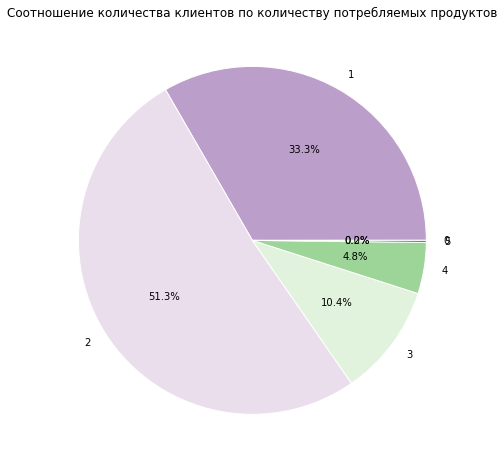

In [87]:
#colors = 'viridis'
count_product = df.groupby('products')['userid'].count()
#colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"]
#colors = ['purple', 'black', 'pink', 'aqua']
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(count_product, labels = count_product.index, autopct='%0.1f%%',  wedgeprops = {"linewidth": 1, "edgecolor": "white"})
ax.set_title('Соотношение количества клиентов по количеству потребляемых продуктов')
plt.show()

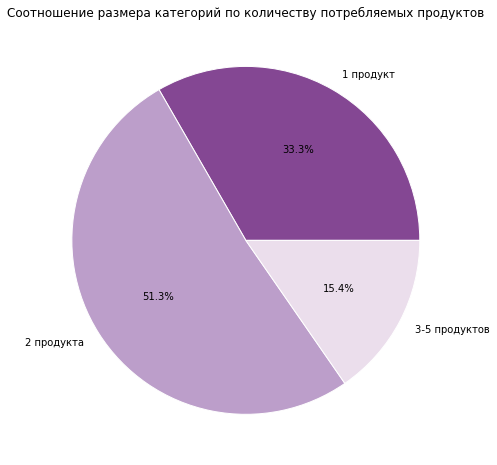

In [88]:
count_product_category = df.groupby('products_category')['products'].count()
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(count_product_category, labels = count_product_category.index, autopct='%0.1f%%',  wedgeprops = {"linewidth": 1, "edgecolor": "white"})
ax.set_title('Соотношение размера категорий по количеству потребляемых продуктов')
plt.show()

2 продукта - наиболее популярный выбор потребителей услуг банка (51.3%). Реже всего встречается комбинация из 3 и более продуктов (15.4%). Владение 1 продуктом встречается в 33.3% случаев. 

## 3.2. Портреты получившихся сегментов ( портрет клиентов для каждого из сегментов по признакам с учетом оттока)

**Признаки клиентов, которые склонны уходить в отток:**
- есть дебетовый счет у клиента или нет
- количество объектов в собственности
- баланс
- количество продуктов
- активность
- кредитный рейтинг

Наиболее выраженная связь:
- активность (0.26)
- собственность (0.35)
- наличие дебетового счета (0.38)
- количество продуктов (0.44)

**Портреты клиентов по всем признакам в разрезе продуктовых категорий и процента ушедших**:

**Наиболее влияющие на отток признаки:**
- наличие дебетового счета (0.36)
- количество объектов в собственности (0.32)
- баланс (0.25)
- активность (0.25)
- рейтинг (0.24)
- количество продуктов (0.23)
- гендер (0.2)

In [89]:
df_new = df[['score_category', 'city', 'age_category','products_category',\
             'equity_category', 'balance_category', 'credit_card', \
             'last_activity', 'est_salary_category', 'churn', 'gender_type','pay_account']]

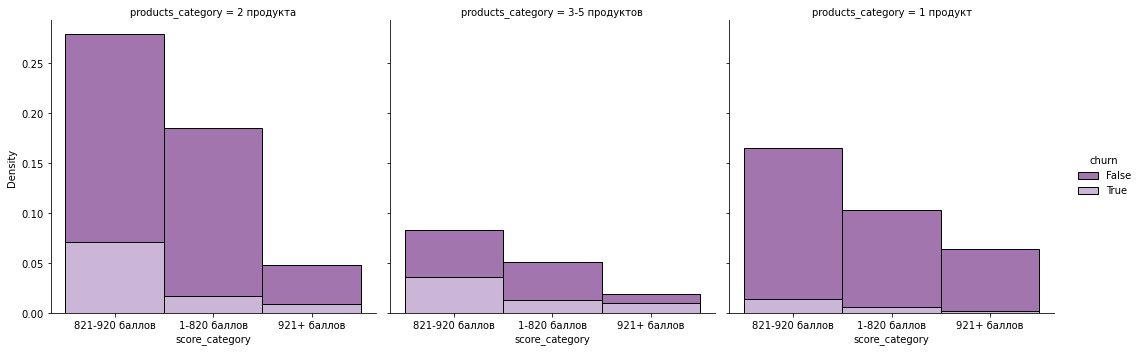

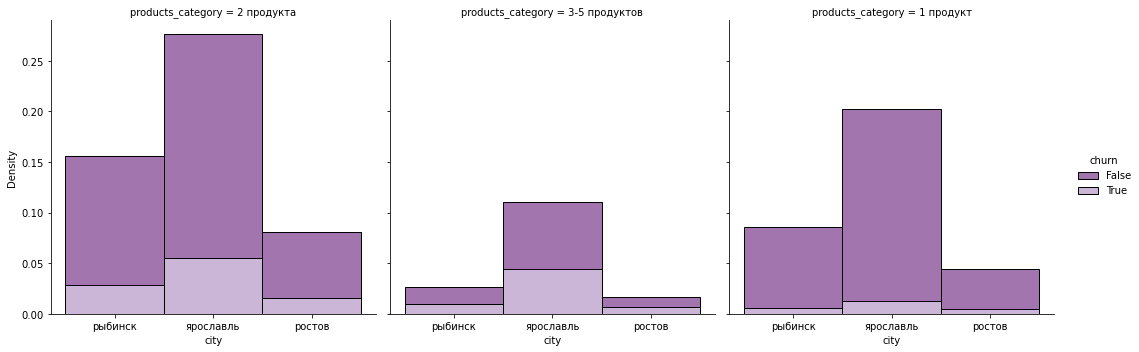

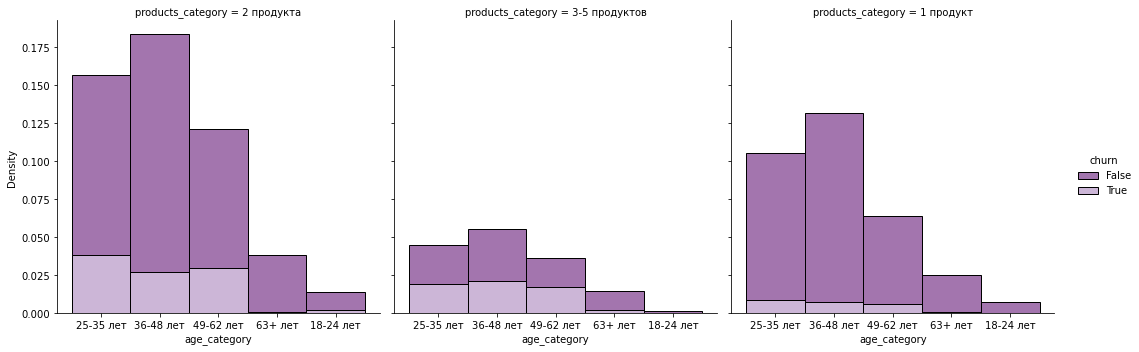

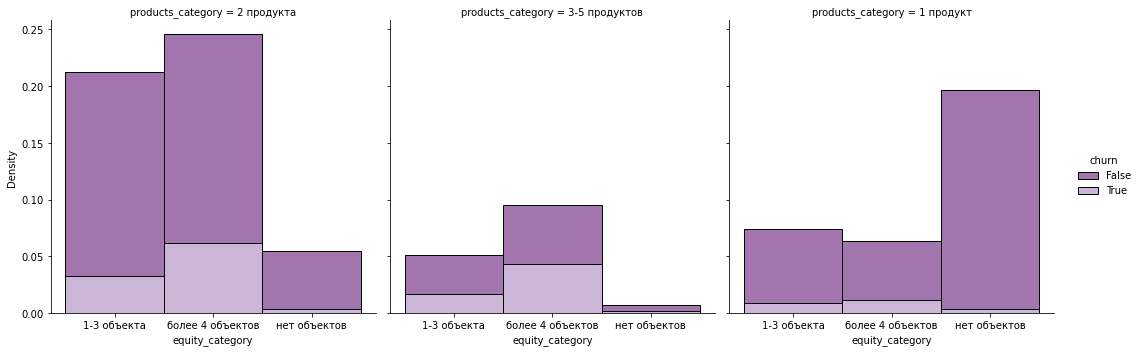

In [90]:
for i in df_new[['score_category', 'city', 'age_category','equity_category']]:
    
    sns.displot(x=i, bins=30,
                col='products_category', hue='churn',
                kde=False, 
                stat="density", 
                multiple="stack",
                data=df_new)

fig, ax = figsize=(20,7)
sns.displot(x='balance_category', bins=10,
                col='products_category', hue='churn',
                kde=False, 
                stat="density", 
                multiple="stack",
                data=df_new)

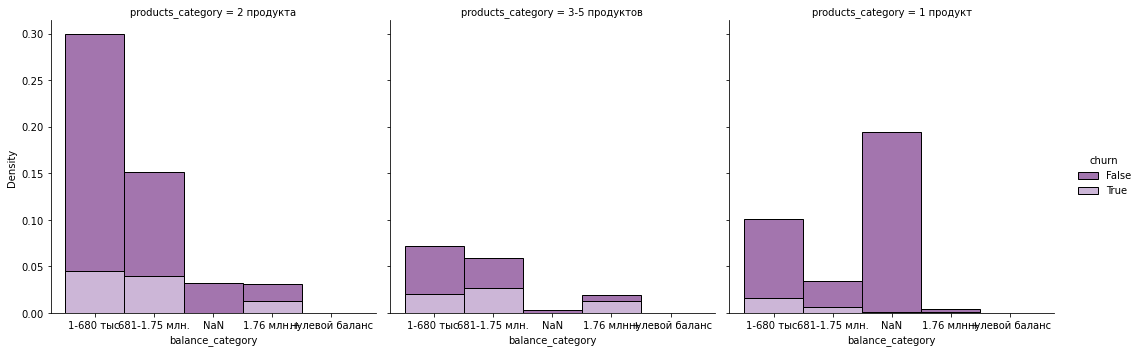

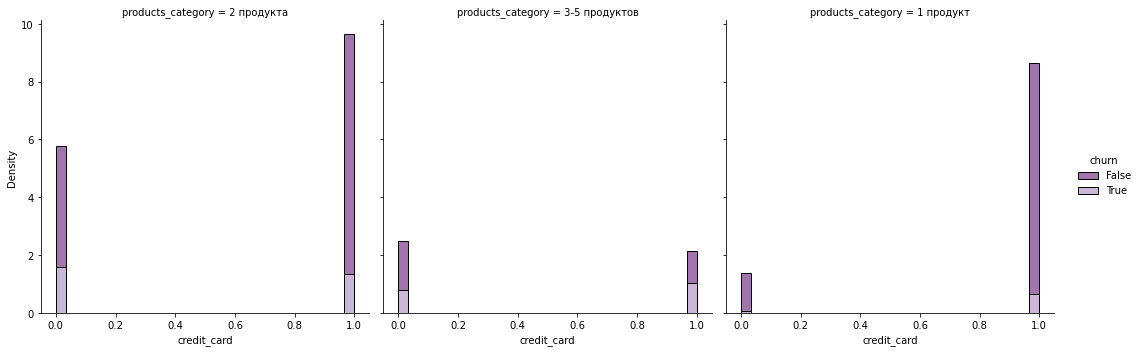

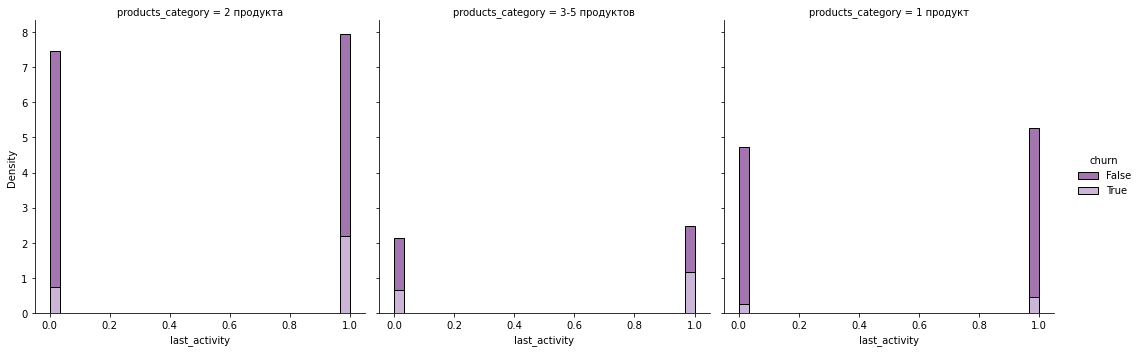

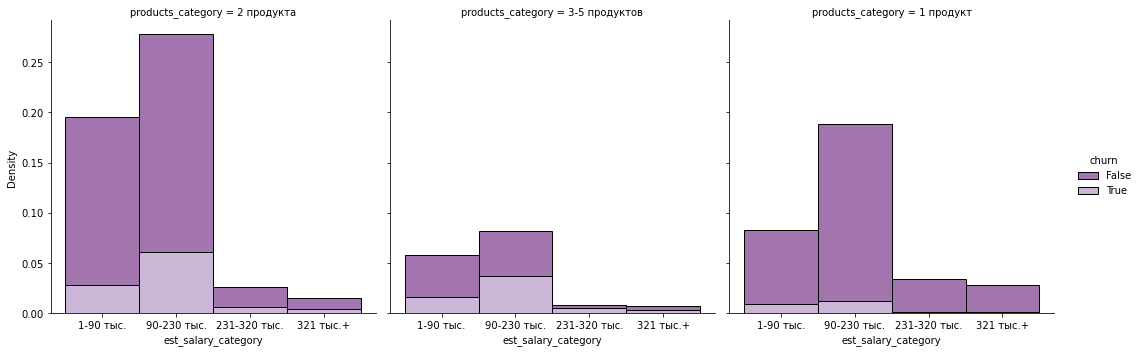

In [91]:
for i in df_new[['balance_category', 'credit_card', 'last_activity', 'est_salary_category']]:
    
    sns.displot(x=i, bins=30,
                col='products_category', hue='churn',
                kde=False, 
                stat="density", 
                multiple="stack",
                data=df_new)

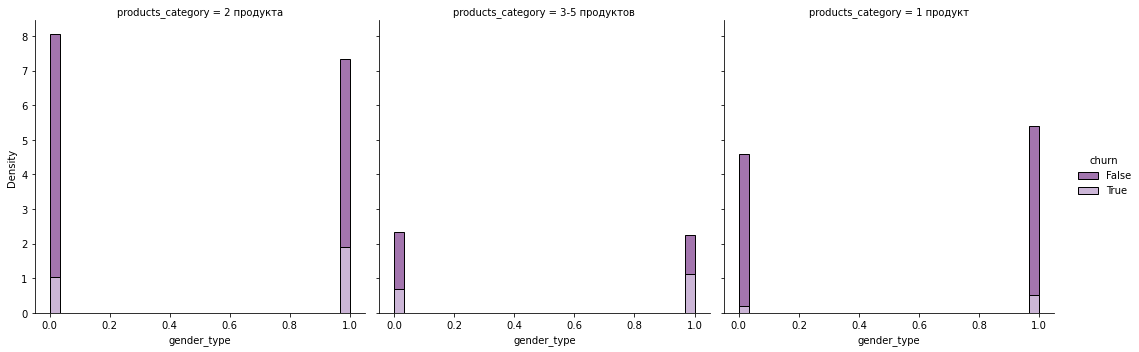

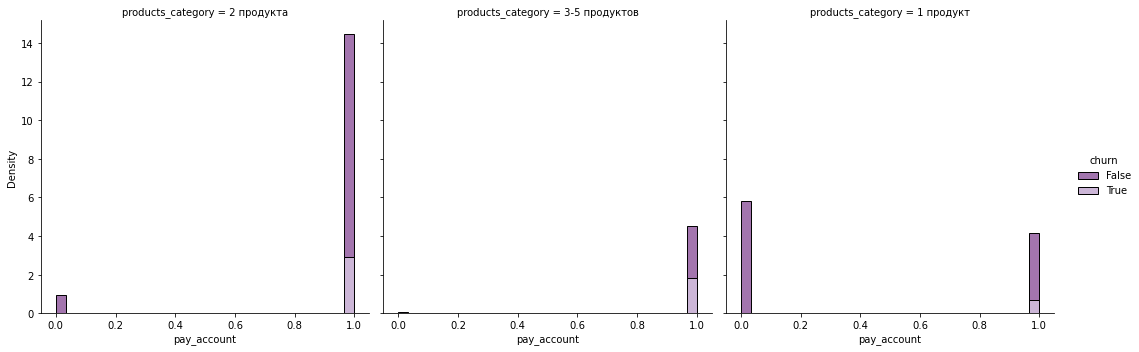

In [92]:
for i in df_new[['gender_type','pay_account']]:
    
    sns.displot(x=i, bins=30,
                col='products_category', hue='churn',
                kde=False, 
                stat="density", 
                multiple="stack",
                data=df_new)

## 3.3. Выводы по наиболее влияющим признакам:
Pay_account:
- реже уходят пользователи, у которых есть платежный аккаунт и которые имеют 2 продукта
- чаще уходят пользователи, у которых есть платежный аккаунт и 3-5 продуктов (ушедшие составляют 40%)

Equity:
-	Среди категории 2 уходят чаще с более 4 объектами (20%)
-	Среди категории 3 уходят чаще с более 4 объектами (40%)
-	среди категории 1 уходят чаще уходят чаще с более 4 объектами (20%)

Balance:
-	Среди категории 2 сильнее отток клиентов с балансом "1 млн.+" и "601 тыс.- 1 млн." (~23%)
-	Среди категории 3 сильнее отток клиентов с балансом 1 млн.+ (50%)
-	Среди категории 1 сильнее отток клиентов с балансом 0-350 тыс

Last_activity:
-	Среди категорий 2 и 3 у активных клиентов сильнее отток, чем у неактивных (категория 2 теряет 25% активных клиентов, категория 3 – 50%)
- У категории 1 отток активных и неактивных клиентов примерно одинаковый (~6.3%)

Score:
-	Наиболее сильный отток у клиентов категории 3 с рейтингом "901+ баллов" (50%) и "801-900 баллов" (40%), с рейтингом "до 800" уходят 25% клиентов
-	Категория 2 теряет 23% клиентов с 801-900 баллами кредитного скоринга, 20% уходят из сегмента с 900+. Наиболее благоприятная ситуация у сегмента до 800 баллов
-	У категории 1 ситуация более оптимистичная: клиенты из сегментов «до 800» и «900+» практически не разрывают отношения с банком. Сегмент «801-900» теряет порядка 9% клиентов.


## 3.4. Сегментация по категориям продуктов и оттоку

**Выделим наиболее отточные сегменты, которые первым делом нужно взять в работу:**

In [122]:
#категория 3, наличие платежного аккаунта, без кредитной карты
super_churn_pay_acc_prod = df.query('pay_account==1 and products >= 3 and credit_card == 0')

#категория 3 и объекты в собственности >=4, зп 100+
super_churn_equity_prod = df.query('equity >= 4 and products >= 3 and est_salary >= 100000')

#категория 3 и активные клиенты
super_churn_prod_act = df.query('products >= 3 and last_activity == 1')

#категория 1 и возраст от 25 до 35
#prod1_age = df.query('products == 1 and age >= 25 and age <= 35 ')

#категория 2, активные клиенты-мужчины
prod2_act = df.query('products == 2 and last_activity == 1 and gender_type == 1')

#категория 2, без кредитной карты
prod2_cred = df.query('products == 2 and credit_card == 0 ')

#категория 1, баланс
#prod1_bal = df.query('products == 1 and balance >=0 and balance <=680000 ')

#категория 1, баланс+ до 681 тыс 
prod1_bal2 = df.query('products == 1 and balance >=0 and balance <=680000')

#категория 1, баланс+ выше 681 тыс 
prod1_bal3 = df.query('products == 1 and balance >=680000 ')

#категория 2, без кредитной карты, зп до 100 тыс включительно
prod2_cred_sal = df.query('products == 2 and credit_card == 0 and est_salary <= 100000 ')

#категория 1, кредитный рейтинг ниже 800
prod1_score_cred = df.query('products == 1 and score <= 800')

In [123]:
print(super_churn_pay_acc_prod.agg({"churn":["mean","sum","count"]}))

print(super_churn_equity_prod.agg({"churn":["mean","sum","count"]}))

print(super_churn_prod_act.agg({"churn":["mean","sum","count"]}))

#print(prod1_age.agg({"churn":["mean","sum","count"]}))

print(prod2_act.agg({"churn":["mean","sum","count"]}))

print(prod2_cred.agg({"churn":["mean","sum","count"]}))


print(prod1_bal2.agg({"churn":["mean","sum","count"]}))

print(prod1_bal3.agg({"churn":["mean","sum","count"]}))

print(prod2_cred_sal.agg({"churn":["mean","sum","count"]}))

print(prod1_score_cred.agg({"churn":["mean","sum","count"]}))

## Общий вывод по продуктовым категориям
- Наиболее нестабильной и плохо удерживаемой категорией по многим признакам является "Категория 3", в которой клиенты имеют 3-5 банковских продуктов
- категория 1, хоть и не является самой многочисленной, имеет наиболее высокие показатели удержания по основным исследуемым сегментам
- чаще покидают банк клиенты категорий 2 и 3 с балансом от 601 тыс. у.е. и выше
- кредитный рейтинг пользователей, покинувших банк, в категориях 2 и 3 высокий (от 800 баллов и выше)
- клиенты, имеющие 1 продукт и рейтинги "до 800 баллв" и "900+ баллов", имеют незначительные показатели оттока


## Вывод по наиболее отточным продуктовым сегментам


**Уходят из нашего банка:**
- 32.7% пользователей, имеющих платежный дебетовый счет и 3+ продуктов без кредитной карты
- 53.3% пользователей с 3+ продуктами и 4+ объектами в собственности с зп 100 тыс+
- 47% активных клиентов с 3+ продуктами
- 36% активных клиентов-мужчин с 2 продуктами
- 27.5% клиентов с 2 банковскими продуктами и без кредитной карты
- 18.5% клиентов с 2 продуктами, зарплатой до 100 тыс и без кредитной карты
- 16.2% клиентов с 1 продуктом и с балансом до 680 

Следует работать с данными сегментами в первую очередь.
 

# 4.Статистическая проверка гипотез

In [95]:
#задалим уровень значимости:
alpha = 0.05

## 4.1. Гипотеза 1
Гипотеза о различии возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

**Формулировка гипотез:**\
Н1_0: средний возраст клиентов, пользующихся одним продуктом банка = среднему возрасту клиентов, пользующихся двумя продуктами\
Н1_1: средний возраст клиентов, пользующихся одним продуктом банка ≠ среднему возрасту клиентов, пользующихся двумя продуктами

#напишем функцию для графической проверки на нормальность распределения значений 'age' для определения теста проверки гипотезы
def disp_col (df,i):
    sns.displot(data=df,x=i,hue='products', kde=True, multiple="stack")
    plt.title('Распределение параметра',fontsize=16)
    plt.show()

disp_col(df,'age')

In [96]:
#формируем необходяимые выборки
products_1=df.query("products==1")
products_2=df.query("products==2")

In [97]:
#удалим пропуски
products_1 = products_1.dropna()
products_2 = products_2.dropna()

**1) Для анализа используем t-test Стьюдента:**\
Критерий Стьюдента проверяет среднее при условии нормальности распределения (при существующей большой выборке этим можно пренебречь) и равности дисперсий, и есть ли зависимость между объектами. Для t-теста стребуется отсутсвие большого числа выбросов в выборке, в нашем случае выбросов нет. 

In [98]:
#пороговое значения уровня стат.значимости
alpha=0.05 

#напишем функцию проверки статистической значимости различий в значениях входящих выборок на основании t-теста (тест Стьюдента)
def t_test(products_1,products_2, i, a): 
    results = st.ttest_ind(
    products_1[i], 
    products_2[i], equal_var=a)
   
    print('p-значение:', results.pvalue)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу: разница статистически значима")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

In [99]:
t_test(products_1,products_2,'age', False)

sns.histplot(x=samples, discrete=True, stat='probability',
             alpha=0.2);

**Не получилось отвергнуть нулевую гипотезу. Это значит, что в среднем возрасте клиентов, пользующихся одним и двумя продуктами нет различия.**

**2) Применим непараметрический критерий Манна-Уитни (u-критерий) для проверки гипотезы**

 Непараметрический критерий, позволяющий
проверить гипотезу о том, что значения двух совокупностей, из которых извлечены сравниваемые
**независимые выборки**, отличаются друг от друга. **Он используется для двух разных выборок, а не одной выборки до и после**

In [100]:
from scipy.stats import mannwhitneyu as mwu

In [101]:
mwu(products_1['age'], products_2['age'])

In [102]:
results = st.mannwhitneyu(products_1['age'], products_2['age'])
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")


In [103]:
print('Среднее значение возраста у клиентов с 1 продуктом:', products_1['age'].mean())
print('Среднее значение возраста у клиентов с 2 продуктами:', products_2['age'].mean())

**По статистическому критерию Манна-Уитни не получилось отвергнуть нулевую гипотезу. Это значит, что в среднем возрасте клиентов, пользующихся одним и двумя продуктами нет различия.**

## 4.2. Гипотеза 2

H2_0: средний баланс на счете клиентов, пользующихся кредитной картой и ушедших из банка = среднему балансу на счете клиента, не пользующегося кредитной картой и ушедшего\
H2_1: средний баланс на счете клиентов, пользующихся кредитной картой и ушедших из банка ≠ средний баланс на счете клиентов, не пользующихся кредитной картой и ушедших из банка

In [104]:
sample_0=df.query("credit_card==1 and churn == True")
sample_1 =df.query("credit_card==0 and churn == True")

In [105]:
sample_0 = sample_0.dropna()
sample_1 = sample_1.dropna()

**1) Используем t-test Стьюдента (Выборки достаточно велики и независимы друг от друга):**

In [106]:
t_test(sample_0,sample_1,'balance', False)

**2) Применим критерий Манна-Уитни (u-критерий):**

In [107]:
results = st.mannwhitneyu(sample_0['balance'], sample_1['balance'])
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

Результаты проверки с помощью  t-test Стьюдента и u-критерия Манна-Уитни оказались идентичны: оба критерия показали различия в рассмотриваемых выборках. Различия в значениях баланса ушедших клиентов с кредитной картой и без кредитной карты являются статистически значимыми. 

## Выводы по статистической оценке гипотез

- в среднем возрасте клиентов, пользующихся одним и двумя продуктами, нет статистически значимой разницы
- в средних значениях баланса ушедших клиентов, пользующихся кредитной картой и не пользующихся кредитной картой, есть статистически значимые различия - они не равны. 

# 5. Общие выводы и рекомендации

## 5.1. Выводы

Целью исследования являлось: провести сегментацию пользователей банка "Метанпромбанк" по потреблению банковских продуктов в разрезе числа используемых продуктов и составить рекомендации для менеджера банковских продуктов по снижению оттока клиентов в определенных сегментах. Определены 3 клиентских категории: "Категория 1" - клиенты с 1 продуктом, "Категория 2" - клиенты с 2 продуктами, "Категория 3" - клиенты с 3-5 продуктами.
- Выявлено, что общей тенденцией для всех клиентов банка  является использование 2 продуктов. При этом наиболее нестабильной и плохо удерживаемой категорией является "Категория 3", в которой клиенты имеют 3-5 банковских продуктов. 

**Отностительно оттока:** 
- самая сильная корреляция зафиксирована между оттоком и количеством продуктов (0.44). Связь прямая. При этом, при взгляде на корреляцию оттока и кредитной карты, обнаружена хоть и слабая, но отрицательная корреляция. Следует рассмотреть возможность предложения кредитной карты некоторым категориям.
- высокая взаимосвязь оттока и наличия платежного аккаунта (дебетового счета) (0.38)
- высока вероятность оттока клиентов с 3 и более объектов в собственности во всех продуктовых категориях
- чем больше объектов в собственности у клиента, тем выше вероятность его ухода (корреляция 0.35)
- наиболее высокие показатели удержания по основным исследуемым сегментам имеют клиенты с 1 банковским продуктом. Также зафиксировано, что клиенты с 1 продуктом, имеют кредитную карту.

**ТОП-5 самых отточных сегмента, которые стоит в первую очередь взять в работу:**
1) активные клиенты с 3+ банковскими продуктами\
2) клиенты с 3+ продуктами и 4+ объектами в собственности с зп 100 тыс.+\
3) активные клиенты-мужчины с 2 продуктами\
4) клиенты с 3+ продуктами, имеющие дебетовый счет, без кредитной карты\
5) клиенты с 2 банковскими продуктами и без кредитной карты


## 5.2. Рекомендации

**Относительно данных:**\
Почти 20% записей о клиентах в выборке содержат пропуски в столбце "balance". Исходя из проведенного анализа, наиболее вероятная причина - отсутствие расчетного счета в банке. Наибольшее количество пропусков зафиксировано у клиентов из Ярославля. Стоит проработать данную особенность и исправить, чтобы не искажать данные и их анализ. Как было описано в разделе "Предобработка данных": Отсутствие расчетного счета и его наличие с нулевым остатком - это разные вещи. 

**Выводы и рекомендации по удержанию:**\
Исходя из сумм на балансе, количества объектов в собственности и кредитного рейтинга, разрывают отношения с банком клиенты с зп 101 тыс.+, которые пользовались большим количеством продуктов нашего банка (3-5 продуктов). Это подтвержает также анализ сегментов заработной платы: наиболее высокими показателями оттока в категории 2 и категории 3 являются пользователи с уровнями зар.плат "101-150 тыс." и "150+ тыс". 

- Сегмент **"Пользователи с 3+ продуктами и 4+ объектами в собственности с зп 100 тыс+"**: Стоит сделать акцент на этих клиентов и предлагать им то, что может их заинтересовать: сберегательные и накопительные счета с высокой процентной ставкой на остаток (можно рассмотреть рост ставки в зависимости от суммы на счете). Предложить иные инвестиционные продукты. Это позволит им быть уверенными в том, что их деньги не просто лежат на счете и обесцениваются из-за инфляции, а работают на благо пользователя.\
Можно рассмотреть предложение таким клиентам индивидуальных инвестиционных рекомендаций.\
Их могут заинтересовать страховые продукты банка по страхованию собственности (если банк занимается страхованием);
- Пользователей из сегментов **"имеющих платежный дебетовый счет и 3+ продуктов без кредитной карты" и "активные клиенты с 3+ продуктами"** могут заинтересовать предложения: дебетовая карта с процентом на остаток и кэшбэком, кредитная карта с беспроцентным периодом от 3-х месяцев, кредитная карта с кэшбэком (зависимым от категории операции по карте). Это стоит предложить и сегменту пользователей с **"с 2 банковскими продуктами и без кредитной карты"**;
- Сегменту **"активные клиенты-мужчины с 2 продуктами"** стоит предложить автокредит с выгодными условиями (возможность сниженной кредитной ставки при условии оформления автострахования в банке и проч.), оформление ОСАГО и КАСКО (конечно, если банк занимается страхованием). Рассмотреть возможность предложения дебетовой карты с опцией повышенного кэшбэка на операции, связанные с автомобилями (покупки в магазинах автотоваров, обслуживание в автосервисах, автомойках и т.п.), на операции, связанные со спортом (фитнес-клубы, магазины спортивных товаров) (это же возможно предложить и женщинам).
- Клиентам с 1 банковским продуктом активно предлагать дополнительный продукт, так как клиенты с двумя продуктами имеют самый низкий отток. Пользователи 1 продукта чаще всего располагают кредитной картой, поэтому предлагать надо иное: кредит (индивидуально, % ставка в зависимости от кредитного рейтинга), либо сберегательные или накопительные счета (рассмотреть клиентов с балансом свыше 680 тыс.)

